In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from build_graph_data import *
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
partition = 200

In [3]:
trainpath = f'../../../data/top30groups/LongLatCombined/train1/train{partition}.csv'
testpath = f'../../../data/top30groups/LongLatCombined/test1/test{partition}.csv'
traindata = pd.read_csv(trainpath, encoding='ISO-8859-1')
testdata = pd.read_csv(testpath, encoding='ISO-8859-1')

In [4]:
traindata.columns

Index(['extended', 'latitude', 'longitude', 'vicinity', 'multiple', 'success',
       'suicide', 'attacktype1', 'targtype1', 'target1', 'individual',
       'weaptype1', 'nkill', 'property', 'ishostkid', 'gname'],
      dtype='object')

In [5]:
combined = pd.concat([traindata, testdata], axis = 0)

In [6]:
combined.shape

(6000, 16)

In [7]:
data = combined

In [8]:
data.columns

Index(['extended', 'latitude', 'longitude', 'vicinity', 'multiple', 'success',
       'suicide', 'attacktype1', 'targtype1', 'target1', 'individual',
       'weaptype1', 'nkill', 'property', 'ishostkid', 'gname'],
      dtype='object')

In [9]:
# Filter dataset to only contain unique coordinates
print("Entries before dropping long/lat duplicates: ", data.shape)

#data.sort_values(by=['longitude', 'latitude', 'attack_date'], inplace=True)

# Keep only relevant columns
data = data[['longitude', 'latitude', 'gname']]
# Drop duplicates based on location, keep the earliest attack
data['longlat'] = list(zip(data['longitude'], data['latitude']))
df_unique = data.drop_duplicates(subset=['longlat'], keep='first').reset_index(drop=True)

df_unique = df_unique.drop(columns=['longitude', 'latitude'])
print(df_unique.columns)
print("Entries after dropping long/lat duplicates (#Nodes): ", df_unique.shape)


Entries before dropping long/lat duplicates:  (6000, 16)
Index(['gname', 'longlat'], dtype='object')
Entries after dropping long/lat duplicates (#Nodes):  (3160, 2)


/tmp/ipykernel_69953/691971201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['longlat'] = list(zip(data['longitude'], data['latitude']))


In [10]:
df_unique["gname"].value_counts()

gname
New People's Army (NPA)                             182
Maoists                                             174
Fulani extremists                                   169
Taliban                                             166
Kurdistan Workers' Party (PKK)                      159
Communist Party of India - Maoist (CPI-Maoist)      158
Revolutionary Armed Forces of Colombia (FARC)       155
Nicaraguan Democratic Force (FDN)                   146
Boko Haram                                          126
Muslim extremists                                   123
Abu Sayyaf Group (ASG)                              120
Tehrik-i-Taliban Pakistan (TTP)                     116
National Liberation Army of Colombia (ELN)          109
Liberation Tigers of Tamil Eelam (LTTE)             109
Islamic State of Iraq and the Levant (ISIL)         107
Farabundo Marti National Liberation Front (FMLN)    103
Houthi extremists (Ansar Allah)                      96
Sikh Extremists                           

In [11]:
split_point = int(0.7 * len(df_unique))
train_df = df_unique[:split_point]
test_df = df_unique[split_point:]

In [12]:
import ast

def to_tuple_if_needed(val):
    if isinstance(val, str):
        return ast.literal_eval(val)
    return val  # already a tuple

df_unique['longlat'] = df_unique['longlat'].apply(to_tuple_if_needed)


In [13]:
from sklearn.model_selection import train_test_split

# 1. Build coord_to_index from the full dataset
full_coords = df_unique[['longlat']]
coord_to_index = {row['longlat']: i for i, row in full_coords.iterrows()}

# 2. Build the global graph
adj_matrix, feature_matrix, label_index = build_graph_data(df_unique, coord_to_index)

# 3. Build train node indices and labels
train_nodes = [coord_to_index[row['longlat']] for _, row in train_df.iterrows()]
train_labels = [label_index[row['gname']] for _, row in train_df.iterrows()]

# 4. Split train into train and validation
train_idx, val_idx, train_lbls, val_lbls = train_test_split(
    train_nodes, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# 5. Build test node indices and labels
test_nodes = [coord_to_index[row['longlat']] for _, row in test_df.iterrows()]
test_labels = [label_index[row['gname']] for _, row in test_df.iterrows()]


Number of total nodes (unique coordinates): 3160
Number of unique labels in this set: 30


In [14]:
print(adj_matrix.shape)

(3160, 3160)


# A simple GCN

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class PyTorchGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.0, activation=F.relu):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.dropout = dropout
        self.activation = activation

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.activation(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


/opt/conda/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [16]:
def run_epoch(model, data, labels, mask, optimizer=None, return_preds=False):
    is_training = optimizer is not None
    if is_training:
        model.train()
    else:
        model.eval()

    out = model(data.x, data.edge_index)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(out[mask], labels[mask])

    if is_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    pred = out[mask].argmax(dim=1)
    acc = (pred == labels[mask]).float().mean().item()

    if return_preds:
        return acc, loss.item(), pred.cpu(), labels[mask].cpu(), out[mask].softmax(dim=1).cpu()
    else:
        return acc, loss.item()


In [17]:
from torch_geometric.data import Data
from scipy.sparse import coo_matrix

# 1. Convert adjacency matrix to edge_index
A_coo = coo_matrix(adj_matrix)
edge_index = torch.tensor(np.vstack((A_coo.row, A_coo.col)), dtype=torch.long)

# 2. Feature matrix
coords = np.array(list(coord_to_index.keys()), dtype=np.float32)
x = torch.tensor(coords, dtype=torch.float32)
num_nodes = x.shape[0]

# 3. Label tensor
y = torch.full((num_nodes,), -1, dtype=torch.long)

# 4. Masks
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# 5. Assign labels and masks
for idx, label in zip(train_idx, train_lbls):
    y[idx] = label
    train_mask[idx] = True

for idx, label in zip(val_idx, val_lbls):
    y[idx] = label
    val_mask[idx] = True

for idx, label in zip(test_nodes, test_labels):
    y[idx] = label
    test_mask[idx] = True

# 6. Create PyG data object
data = Data(x=x, edge_index=edge_index)


In [18]:
from itertools import product
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


hidden_dims = [10, 50, 100, 150]
lrs = [0.01, 0.001, 0.0001]
weight_decays = [0]
dropouts = [0.0]
activation_functions = [F.relu, torch.tanh]

best_config = None
best_val_acc = 0

patience = 100
max_epochs_search = 500
max_epochs_final = 1500

# --------------------------
# Grid search (NO test use!)
# --------------------------
for hidden, lr, wd, do, act in product(hidden_dims, lrs, weight_decays, dropouts, activation_functions):
    model = PyTorchGCN(
        in_channels=x.shape[1],
        hidden_channels=hidden,
        num_classes=len(label_index),
        dropout=do,
        activation=act
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    best_val_acc_run = 0
    patience_counter = 0

    for epoch in range(max_epochs_search):
        train_acc, train_loss = run_epoch(model, data, y, train_mask, optimizer)
        val_acc, val_loss = run_epoch(model, data, y, val_mask)

        if epoch == 0:
            print(f"Evaluating hidden={hidden}, lr={lr}, weight_decay={wd}, dropout={do}, activation={act.__name__}")
        elif epoch % 100 == 0 or epoch == max_epochs_search - 1:
            print(f"Epoch {epoch:04d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc_run:
            best_val_acc_run = val_acc
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping.")
            break

    # Track best config
    if best_val_acc_run > best_val_acc:
        best_val_acc = best_val_acc_run
        best_config = (hidden, lr, wd, do, act)

print(f"\nBest config found:")
print(f"hidden={best_config[0]}, lr={best_config[1]}, weight_decay={best_config[2]}, dropout={best_config[3]}, activation={best_config[4].__name__}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# --------------------------
# Retrain best config, then test
# --------------------------

# Rebuild model and optimizer
model = PyTorchGCN(
    in_channels=x.shape[1],
    hidden_channels=best_config[0],
    num_classes=len(label_index),
    dropout=best_config[3],
    activation=best_config[4]
)
optimizer = torch.optim.Adam(model.parameters(), lr=best_config[1], weight_decay=best_config[2])

# Early stopping on validation again
best_val_acc_run = 0
patience_counter = 0
best_model_state = None

for epoch in range(max_epochs_final):
    train_acc, train_loss = run_epoch(model, data, y, train_mask, optimizer)
    val_acc, val_loss = run_epoch(model, data, y, val_mask)

    if val_acc > best_val_acc_run:
        best_val_acc_run = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping during final retrain. Epoch: {epoch}")
        break

# Load best model
model.load_state_dict(best_model_state)
model.eval()

# Final test evaluation
test_acc, test_loss, preds, targets, probs = run_epoch(model, data, y, test_mask, return_preds=True)

print(f"\nFinal test accuracy after retraining with best config: {test_acc:.4f}")

# Compute metrics
accuracy = accuracy_score(targets, preds)
precision = precision_score(targets, preds, average='weighted', zero_division=0)
recall = recall_score(targets, preds, average='weighted', zero_division=0)
f1_micro = f1_score(targets, preds, average='micro', zero_division=0)
f1_macro = f1_score(targets, preds, average='macro', zero_division=0)

try:
    y_true_bin = torch.nn.functional.one_hot(targets, num_classes=probs.shape[1]).detach().numpy()
    rocauc = roc_auc_score(y_true_bin, probs.detach().numpy(), average='weighted', multi_class='ovr')
except Exception as e:
    print("ROCAUC computation failed:", e)
    rocauc = None

# Write to file
with open(f"test_metricsgtd{partition}.txt", "w") as f:
    f.write("Best Model Hyperparameters:\n")
    f.write(f"  Hidden dim     : {best_config[0]}\n")
    f.write(f"  Learning rate  : {best_config[1]}\n")
    f.write(f"  Weight decay   : {best_config[2]}\n")
    f.write(f"  Dropout        : {best_config[3]}\n")
    f.write(f"  Activation     : {best_config[4].__name__}\n")
    f.write("\nPerformance on Test Set:\n")
    f.write(f"Test Accuracy        : {accuracy:.4f}\n")
    f.write(f"Precision (weighted) : {precision:.4f}\n")
    f.write(f"Recall (weighted)    : {recall:.4f}\n")
    f.write(f"F1 Score (micro)     : {f1_micro:.4f}\n")
    f.write(f"F1 Score (macro)     : {f1_macro:.4f}\n")
    if rocauc is not None:
        f.write(f"ROC AUC (weighted)   : {rocauc:.4f}\n")
    else:
        f.write("ROC AUC              : Not computed (only one class or failed)\n")


Evaluating hidden=10, lr=0.01, weight_decay=0, dropout=0.0, activation=relu
Epoch 0100 | Train Loss: 1.5164 | Val Loss: 1.5806 | Train Acc: 0.4771 | Val Acc: 0.4853
Epoch 0200 | Train Loss: 1.1896 | Val Loss: 1.2267 | Train Acc: 0.5523 | Val Acc: 0.5463
Epoch 0300 | Train Loss: 0.9845 | Val Loss: 1.0189 | Train Acc: 0.6365 | Val Acc: 0.6546
Epoch 0400 | Train Loss: 0.8677 | Val Loss: 0.9001 | Train Acc: 0.6874 | Val Acc: 0.6953
Epoch 0499 | Train Loss: 0.7904 | Val Loss: 0.8183 | Train Acc: 0.7241 | Val Acc: 0.7336
Evaluating hidden=10, lr=0.01, weight_decay=0, dropout=0.0, activation=tanh
Epoch 0100 | Train Loss: 1.9261 | Val Loss: 1.9111 | Train Acc: 0.3335 | Val Acc: 0.3363
Epoch 0200 | Train Loss: 1.3807 | Val Loss: 1.3793 | Train Acc: 0.4488 | Val Acc: 0.4537
Epoch 0300 | Train Loss: 1.1556 | Val Loss: 1.1674 | Train Acc: 0.5783 | Val Acc: 0.5711
Epoch 0400 | Train Loss: 1.0677 | Val Loss: 1.0910 | Train Acc: 0.6032 | Val Acc: 0.5914
Epoch 0499 | Train Loss: 1.0131 | Val Loss: 1.0

In [19]:
print(best_config)

(150, 0.01, 0, 0.0, <built-in method tanh of type object at 0x7f61f00817c0>)


In [20]:
model = PyTorchGCN(
    in_channels=x.shape[1],
    hidden_channels=best_config[0],
    num_classes=len(label_index),
    dropout=best_config[3],
    activation=best_config[4]
)
model.load_state_dict(best_model_state)
model.eval()



PyTorchGCN(
  (conv1): GCNConv(2, 150)
  (conv2): GCNConv(150, 30)
)

In [21]:
id_to_label = {v: k for k, v in label_index.items()}
target_names = [id_to_label[i] for i in sorted(id_to_label)]
print(classification_report(targets, preds, target_names=target_names))

                                                  precision    recall  f1-score   support

                                         Taliban       0.95      0.73      0.83        49
   Revolutionary Armed Forces of Colombia (FARC)       0.76      0.65      0.70        48
  Communist Party of India - Maoist (CPI-Maoist)       0.58      0.63      0.61        49
                     Irish Republican Army (IRA)       0.83      0.91      0.87        11
                                         Maoists       0.59      0.65      0.62        54
             Basque Fatherland and Freedom (ETA)       0.91      0.95      0.93        21
                                 Sikh Extremists       0.81      0.73      0.77        30
      National Liberation Army of Colombia (ELN)       0.65      0.67      0.66        42
                  Kurdistan Workers' Party (PKK)       0.79      0.85      0.81        52
                         New People's Army (NPA)       0.91      0.83      0.87        59
         

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


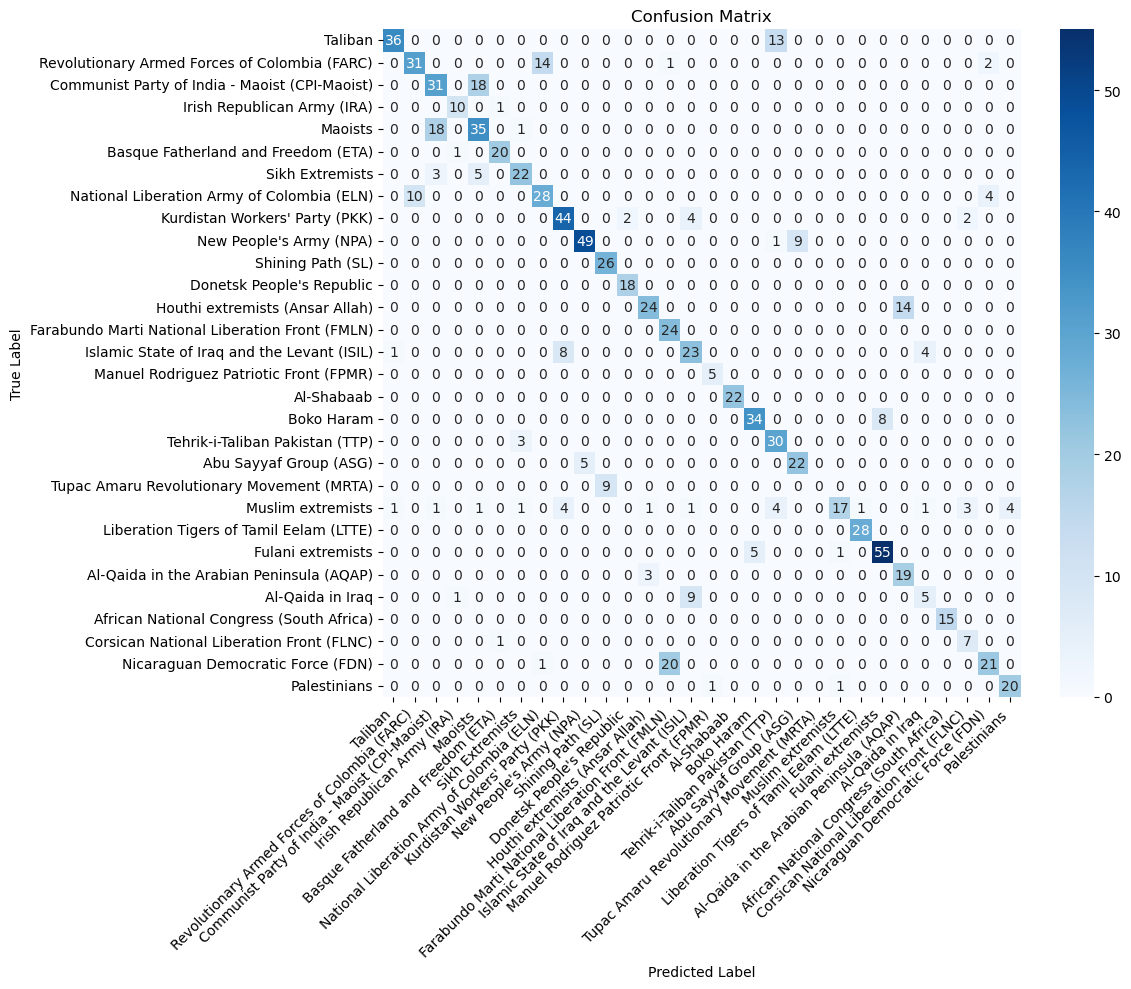

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(targets, preds)
plt.figure(figsize=(12, 10))  # Adjust size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"confusion_matrix_gtd{partition}.png", dpi=300)

plt.show()



In [23]:
plt.savefig(f"confusion_matrix_gtd{partition}.png", dpi=300)


<Figure size 640x480 with 0 Axes>